# Predicting logP with graph neural networks using spektral
In this notebook, we will build a graph neural network with Spektral (www.graphneural.network/) that predicts the logP value (octanol-water partition coefficient) of molecules. First, we will load the used libraries:

In [1]:
import absl.logging
import logging
import warnings
import random 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

import spektral as spektral
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalAttentionPool

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

seed = 3
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

print(f"Tensorflow version: {tf.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Spektral version: {spektral.__version__}")

Tensorflow version: 2.5.0
Numpy version: 1.19.5
Spektral version: 1.1.0


# Dataset
Now we will load the dataset. The dataset originates from following publication:
- Ulrich, Goss & Ebert, Exploring the octanol–water partition coefficient dataset using deep learning techniques and data augmentation. *Communications Chemistry* **2021**, *4*, 90. www.doi.org/10.1038/s42004-021-00528-9

It can be found via following link: www.github.com/nadinulrich/log_P_prediction/blob/main/Dataset_and_Predictions.xlsx
In the reduced version of the file used here, the dataset contains SMILES strings, logP labels and the unique CAS identifiers. In total, there are 12709 entries in this dataset:

In [2]:
df_dataset = pd.read_csv("dataset.csv")
df_dataset.sample(3)

,SMILES,CAS,logP
1384,CCC=C(N)O,541-35-5,-0.21
8097,[H]OC(N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H...,132766-08-6,-1.56
10067,CCOC1=CC=C(C=C1OCC)N=C(O)OC(C)COC,NOCAS_874743,2.56


In [3]:
len(df_dataset)

12709

However, there are only 1386 unique molecules in the dataset. This is because Kuhn et al. - where applicable - included multiple tautomeric structures (but apparently also enantiomers?) of the same molecule as a form of data augmentation. An example of multiple tautomers/enantiomers can be found below. I have not checked the usefulness of this (but for enantiomers I expect it to be rather detrimental) but in this notebook we do not want to bother with this.

In [4]:
unique_CAS = df_dataset.CAS.unique()
len(unique_CAS)

1386

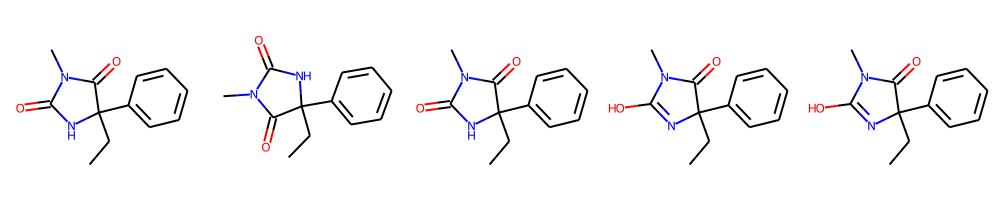

In [5]:
Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in df_dataset.SMILES[0:5]], molsPerRow=5)

# Creating a Spektral Dataset

The spektral package has its own dataset class to store graphs. We will create these datasets in the following. Each graph can be described by an adjacency matrix, a node (atom) feature matrix, and a edge (bond) feature matrix. For the edge feature matrix, we will include information about the bond type (e.g. single or double bond). For the node feature matrix, we will  include information about the atom type (e.g. carbon or nitrogen). But for this, we first need to know which atom and bond types there are in our dataset. For the bonds, there are following types:

In [6]:
df_dataset_mol = df_dataset.SMILES.apply(Chem.MolFromSmiles)

bond_types = []
for mol in df_dataset_mol:
    bonds = mol.GetBonds()
    for bond in bonds:
        bond_type = str(bond.GetBondType())
        if bond_type not in bond_types:
            bond_types.append(bond_type)          
bond_types

['SINGLE', 'DOUBLE', 'AROMATIC', 'TRIPLE']

For the atoms, there are following types:

In [7]:
atom_types = []
for mol in df_dataset_mol:
    atoms = mol.GetAtoms()
    for atom in atoms:
        atom_type = str(atom.GetSymbol())
        if atom_type not in atom_types:
            atom_types.append(atom_type)           
atom_types

['C', 'N', 'O', 'S', 'P', 'Cl', 'F', 'Br', 'I', 'Si']

The class below will create our spektral graph objects:

In [8]:
class MolecularGraph:
    def __init__(self, SMILES, label, bond_types, atom_types):
        """
        Parameters
        ----------
        SMILES : str
        label: float/int/str...
        bond_types: list of str
        atom_types: list of str
        """
        
        self.SMILES = SMILES
        self.label = label
        self.bond_types = bond_types
        self.atom_types = atom_types
        
        self.mol = Chem.MolFromSmiles(SMILES)
        self.adjacency_matrix = Chem.GetAdjacencyMatrix(self.mol)
        self.edge_attributes = self.get_edge_attributes()
        self.node_attributes = self.get_node_attributes()
        
    
    def get_edge_attributes(self):
        n_edges = np.sum(self.adjacency_matrix)
        n_edge_features = len(self.bond_types)
        edge_attributes = np.zeros(shape=(n_edges, n_edge_features), dtype=int)
        
        (edge_start_idx, edge_end_idx) = np.where(self.adjacency_matrix==1)
        for count, (idx1, idx2) in enumerate(zip(edge_start_idx, edge_end_idx)):
            bond_type = str((self.mol).GetBondBetweenAtoms(int(idx1), int(idx2)).GetBondType())
            if bond_type in self.bond_types:
                idx3 = self.bond_types.index(bond_type)
                edge_attributes[count, idx3] = 1
        return edge_attributes

        
    def get_node_attributes(self):
        n_nodes = self.adjacency_matrix.shape[0]
        n_node_features = len(self.atom_types)  
        node_attributes = np.zeros(shape=(n_nodes, n_node_features), dtype=float)
        
        for count, atom in enumerate(self.mol.GetAtoms()):
            atom_type = str(atom.GetSymbol())
            if atom_type in self.atom_types:
                idx = self.atom_types.index(atom_type)
                node_attributes[count, idx] = 1        
        return node_attributes
                

    def get_graph(self):
        self.graph = Graph(x=self.node_attributes, a=self.adjacency_matrix, e=self.edge_attributes, y=self.label)
        return self.graph

To give you an idea how adjacency matrix, edge feature matrix, and node feature matrix look like, I will display them for a simple molecule (we will only use atom and bond types that are present in this molecule for edge and node feature matrix for simplicity). This is our example molecule:

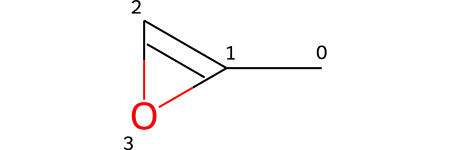

In [9]:
mol = Chem.MolFromSmiles("CC1=CO1")
for idx, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("atomNote", str(idx))

mol

The adjacency matrix for this for the molecule (rows and columns both represent the atom numbers from 0 to 3 as numbered above) can be found below:

In [10]:
graph1 = MolecularGraph("CC1=CO1", None, ["SINGLE", "DOUBLE"], ["C", "O"]) 
graph1.adjacency_matrix

array([[0, 1, 0, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 1],
       [0, 1, 1, 0]], dtype=int32)

The node feature matrix looks like this (columns represent atom types carbon and oxygen, rows represent the atom number from 0 to 3 as numbered above):

In [11]:
graph1.node_attributes

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

The edge feature matrix looks like this (columns represent bond type single and double, rows represent the bonds in order as they appear in the adjacency matrix (mean the first bond will be the bond between atom 0 and 1, the second bond will be the bond between atom 1 and 0, the third bond will be the bond between atom 1 and 3, and so on)):

In [12]:
graph1.edge_attributes

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]])

Before we finally create our spektral dataset, we will split the dataset into train, validation, and test set with proportions of approximately 80:20:20. To avoid data leakage, we do this in a way that ensures that different tautomeric structures of the same molecule only appear in one of different portions of the sets:

In [13]:
rs1 = ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train, test in rs1.split(unique_CAS):
    train_validation_CAS = unique_CAS[train]
    test_CAS = unique_CAS[test]
    
rs2 = ShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
for train, validation in rs2.split(train_validation_CAS):
    validation_CAS = train_validation_CAS[validation]
    train_CAS = train_validation_CAS[train]
    
df_train = df_dataset[df_dataset.CAS.isin(train_CAS)]
df_validation = df_dataset[df_dataset.CAS.isin(validation_CAS)]
df_test = df_dataset[df_dataset.CAS.isin(test_CAS)]

Furthermore, we perform min-max-scaling of our logP target variable:

In [14]:
df_train_transformed = df_train.copy()
df_validation_transformed = df_validation.copy()
df_test_transformed = df_test.copy()

scaler_logP = MinMaxScaler()
scaler_logP.fit(df_train.logP.to_numpy().reshape(-1, 1))

df_train_transformed.logP = (scaler_logP.transform(df_train.logP.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]
df_validation_transformed.logP = (scaler_logP.transform(df_validation.logP.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]
df_test_transformed.logP = (scaler_logP.transform(df_test.logP.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]

Now we implement the CustomDataset class that uses our MolecularGraph class to create our own custom made spektral datasets:

In [15]:
class CustomDataset(Dataset):
    def __init__(self, SMILES, labels, bond_types, atom_types):
        """
        Parameters
        ----------
        SMILES : pd.Series
        label: pd.Series
        bond_types: list of str
        atom_types: list of str
        """
        
        self.SMILES = SMILES
        self.labels = labels
        self.bond_types = bond_types
        self.atom_types = atom_types
        super().__init__()
        
    def read(self):
        graphs = []
        for count, SMILE in self.SMILES.items():   
            graph = MolecularGraph(SMILE, self.labels[count], self.bond_types, self.atom_types).get_graph()
            graphs.append(graph)
        return graphs

And finally let's create the datasets:

In [16]:
train_dataset = CustomDataset(df_train_transformed.SMILES, df_train_transformed.logP, bond_types, atom_types)
validation_dataset = CustomDataset(df_validation_transformed.SMILES, df_validation_transformed.logP, bond_types, atom_types)
test_dataset = CustomDataset(df_test_transformed.SMILES, df_test_transformed.logP, bond_types, atom_types)

# A baseline model for performance comparison
The RDKit offers an out-of-the-box predictor for logP values:

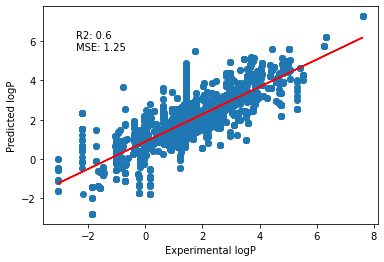

In [17]:
df_test_mol = df_test.SMILES.apply(Chem.MolFromSmiles)
y_test_pred = df_test_mol.apply(Descriptors.MolLogP)

fig, ax = plt.subplots()
ax.scatter(df_test.logP, y_test_pred)
m, b = np.polyfit(df_test.logP, y_test_pred, 1)
ax.plot(df_test.logP, (m * df_test.logP + b), color="red")
ax.set_xlabel("Experimental logP")
ax.set_ylabel("Predicted logP")
ax.text(0.1, 0.8, f"""R2: {round(r2_score(df_test.logP, y_test_pred), 2)} 
MSE: {round(mean_squared_error(df_test.logP, y_test_pred), 2)}""", transform=ax.transAxes)

plt.show()

# Training the graph neural network
First, we will create our network architecture:

In [18]:
def get_model(n_node_features, n_edge_features):
    x_in = Input(shape=(n_node_features,))
    a_in = Input(shape=(None,), sparse=True)
    e_in = Input(shape=(n_edge_features,))
    i_in = Input(shape=(), dtype=tf.int32)
    
    x1 = ECCConv(128, kernel_network=[8, 32, 32, 8], activation="relu")([x_in, a_in, e_in])
    x2 = Dropout(0.1)(x1)
    x3 = ECCConv(128, kernel_network=[8, 32, 32, 8], activation="relu")([x2, a_in, e_in])
    x4 = Dropout(0.1)(x3)
    x5 = ECCConv(128, kernel_network=[8, 32, 32, 8], activation="relu")([x4, a_in, e_in])

    x6 = GlobalAttentionPool(256)([x5, i_in])

    x7 = Dense(128)(x6)
    x8 = Dropout(0.4)(x7)
    x9 = Dense(128)(x8)
    x10 = Dense(1)(x9)

    model = Model(inputs=[x_in, a_in, e_in, i_in], outputs=x10)
    model.summary()
    
    return model

gnn1 = get_model(len(atom_types), len(bond_types))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
ecc_conv (ECCConv)              (None, 128)          14576       input_1[0][0]                    
                                                                 input_2[0][0]                

Then we create some loaders that will feed the batches into our network during training:

In [19]:
batch_size = 64

train_dataset_loader = DisjointLoader(train_dataset, batch_size=batch_size)
validation_dataset_loader = DisjointLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataset_loader = DisjointLoader(test_dataset, batch_size=batch_size, shuffle=False)

Compiling and training:

In [20]:
gnn1.compile(optimizer=Adam(learning_rate=0.00025), loss=MeanSquaredError()) 


def scheduler(epoch, lr): 
    return lr * 0.98


cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=25)  
cb2 = callbacks.LearningRateScheduler(scheduler)
cb3 = callbacks.ModelCheckpoint(".\\gnn1", monitor="val_loss", save_best_only=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history = gnn1.fit(train_dataset_loader.load(), 
                       steps_per_epoch=train_dataset_loader.steps_per_epoch,
                       validation_data=validation_dataset_loader.load(),
                       validation_steps=validation_dataset_loader.steps_per_epoch,
                       epochs=200,
                       callbacks=[cb1, cb2, cb3])

Epoch 1/200
122/122 [==============================] - 68s 542ms/step - loss: 0.0835 - val_loss: 0.0172
Epoch 2/200
122/122 [==============================] - 68s 559ms/step - loss: 0.0166 - val_loss: 0.0123
Epoch 3/200
122/122 [==============================] - 65s 533ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 4/200
122/122 [==============================] - 65s 534ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 5/200
122/122 [==============================] - 66s 544ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 6/200
122/122 [==============================] - 64s 522ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 7/200
122/122 [==============================] - 62s 508ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 8/200
122/122 [==============================] - 60s 495ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 9/200
122/122 [==============================] - 61s 500ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 10/200
122/122 [==============================] - 60s 489m

122/122 [==============================] - 59s 481ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 80/200
122/122 [==============================] - 59s 483ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 81/200
122/122 [==============================] - 59s 480ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 82/200
122/122 [==============================] - 58s 474ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 83/200
122/122 [==============================] - 58s 473ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 84/200
122/122 [==============================] - 58s 479ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 85/200
122/122 [==============================] - 58s 478ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 00085: early stopping


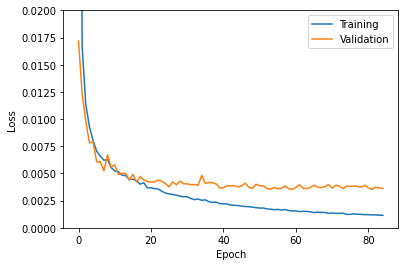

In [21]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"], label="Training")
ax.plot(history.history["val_loss"], label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(0, 0.02)
plt.show()

And finally, let's check the performance of our model:

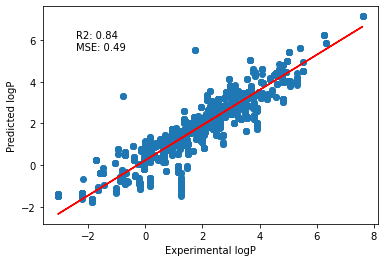

In [22]:
gnn1 = tf.keras.models.load_model(".\\gnn1", compile=False)
y_test_pred = gnn1.predict(test_dataset_loader.load(), steps=test_dataset_loader.steps_per_epoch)
y_test_pred_backtransformed = scaler_logP.inverse_transform(y_test_pred).reshape(1, -1)[0]

fig, ax = plt.subplots()
ax.scatter(df_test.logP, y_test_pred_backtransformed)
m, b = np.polyfit(df_test.logP, y_test_pred_backtransformed, 1)
ax.plot(df_test.logP, (m * df_test.logP + b), color="red")
ax.set_xlabel("Experimental logP")
ax.set_ylabel("Predicted logP")
ax.text(0.1, 0.8, f"""R2: {round(r2_score(df_test.logP, y_test_pred_backtransformed), 2)} 
MSE: {round(mean_squared_error(df_test.logP, y_test_pred_backtransformed), 2)}""", transform=ax.transAxes)
plt.show()